# Airbnb Dublin Market Analysis

## Content

- [Assignment](#assgnmt)
- [Preparation](#prep)
- [Search Patterns Exploration](#search_patt)
- [Hosts Acceptance Exploration](#host_accpt)

## Assignment <a id="assgnmt"></a>
New Airbnb manager in Dublin want to understand demand/supply in the market, especially:
- what guests are searching for in Dublin;
- which inquiries hosts tend to accept;
- understand overall gaps between guests demand and host supply to increase the number of bookings.

For this, two datasets are given with info within 14 days (1-Oct - 14-Oct):
- `searches` - contains info about users and what filters they apply to search in Airbnb.
- `contacts` - contains info for every time that an assigned visitor makes an inquiry for a stay in a listing.


*[fields description](airbnb_datasets_info.txt)

## Preparation <a id="prep"></a>

In [1]:
#Import Libraries and datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


contacts = pd.read_csv('contacts.tsv', sep='\t')
searches = pd.read_csv('searches.tsv', sep='\t')

## Search Patterns Exploration <a id="search_patt"></a>
On this stage following questions will be explored:
1. How long guests want to stay in?
2. How many guest want to stay in one home?
3. How soon guest want the room?
4. What type of housing do guests usually look for?
5. How much money do guests plan to spend on housing?
6. What neighborhood preferable?
7. From what countries are they?

In [2]:
#Undrstand types of data in the dataset
searches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35737 entries, 0 to 35736
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ds                    35737 non-null  object 
 1   id_user               35737 non-null  object 
 2   ds_checkin            23888 non-null  object 
 3   ds_checkout           23888 non-null  object 
 4   n_searches            35737 non-null  int64  
 5   n_nights              23888 non-null  float64
 6   n_guests_min          35737 non-null  int64  
 7   n_guests_max          35737 non-null  int64  
 8   origin_country        35737 non-null  object 
 9   filter_price_min      13322 non-null  float64
 10  filter_price_max      13322 non-null  float64
 11  filter_room_types     16191 non-null  object 
 12  filter_neighborhoods  1346 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 3.5+ MB


In [3]:
#Change string date fields to datetime format for easier analysis
searches['ds'] = pd.to_datetime(searches['ds'])
searches['ds_checkout'] = pd.to_datetime(searches['ds_checkout'])
searches['ds_checkin'] = pd.to_datetime(searches['ds_checkin'])

In [4]:
#Understand basic statistics and outliers
searches.describe()

,n_searches,n_nights,n_guests_min,n_guests_max,filter_price_min,filter_price_max
count,35737.000000,23888.000000,35737.000000,35737.000000,13322.000000,1.332200e+04
mean,9.206565,7.672765,1.742955,2.105857,8.470200,9.019063e+07
std,17.348746,21.557614,1.460440,1.817358,53.987679,2.978482e+08
min,1.000000,0.000000,1.000000,1.000000,0.000000,9.000000e+00
25%,1.000000,2.000000,1.000000,1.000000,0.000000,8.600000e+01
50%,4.000000,3.000000,1.000000,2.000000,0.000000,1.390000e+02
75%,10.000000,5.000000,2.000000,2.000000,0.000000,3.010000e+02
max,448.000000,399.000000,16.000000,16.000000,1250.000000,1.073742e+09


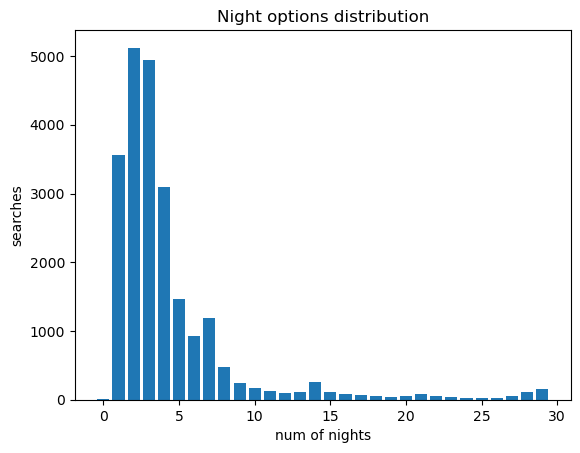

In [5]:
#Find how long do usually guest want to stay in (num of nights)
nights_count = searches.groupby('n_nights').id_user.count().reset_index()

#Due to dramatic outliers present, set limit of 95% data (up to 29 day)
perc_95 = np.percentile(searches[searches['n_nights'].notna()]['n_nights'], 95)
nights_count = nights_count[nights_count['n_nights']<=perc_95]

#Build bar chart to compare
plt.bar(nights_count['n_nights'], nights_count['id_user'])
plt.xlabel('num of nights')
plt.ylabel('searches')
plt.title('Night options distribution')

plt.show()

Most popular option is 2 and 3 being the next popular option.
Generally, guests plan to stay in between 2 and 5 days (50% of distribution)

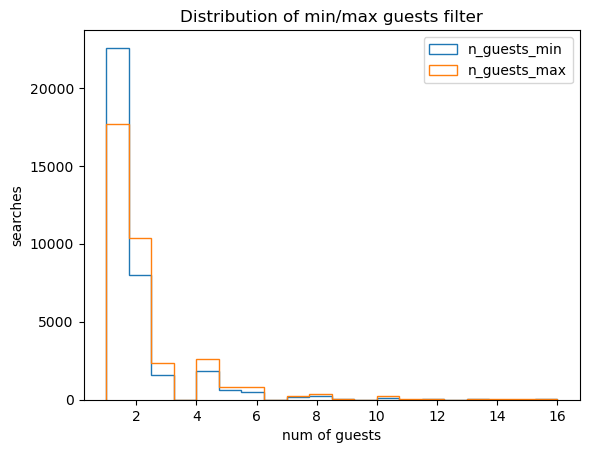

In [6]:
#Build distribution plot of max and min expected guests to determine popular sceneries
plt.hist(searches['n_guests_min'], histtype='step', bins=20, label='n_guests_min')
plt.hist(searches['n_guests_max'], histtype='step', bins=20, label='n_guests_max')
plt.xlabel('num of guests')
plt.ylabel('searches')
plt.title('Distribution of min/max guests filter')
plt.legend()

plt.show()

Both have similar distribution and generally most of the users looks for house for 1-2 person

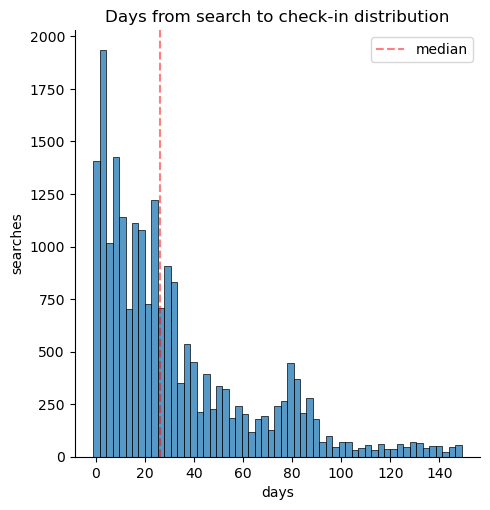

In [7]:
#How many days do people get ready before the trip?
#Add field 'prep_duration' (diff between search and check-in date) for more convenience during calculation
searches['prep_duration'] = searches['ds_checkin'] - searches['ds']

prep_distr = searches['prep_duration'].dropna().dt.days

#Build distribution and keep only values below 150 (it's 90% of data) due to extreme outliers
prep_distr_150 = prep_distr[prep_distr<150]

sns.displot(x=prep_distr_150)
plt.axvline(np.median(prep_distr), color='red', linestyle='--', alpha=0.5, label='median')
plt.xlabel('days')
plt.ylabel('searches')
plt.title('Days from search to check-in distribution')
plt.legend()

plt.show()

People are usually looking for a house for 10-67 dasys in advance (median - 26 days)

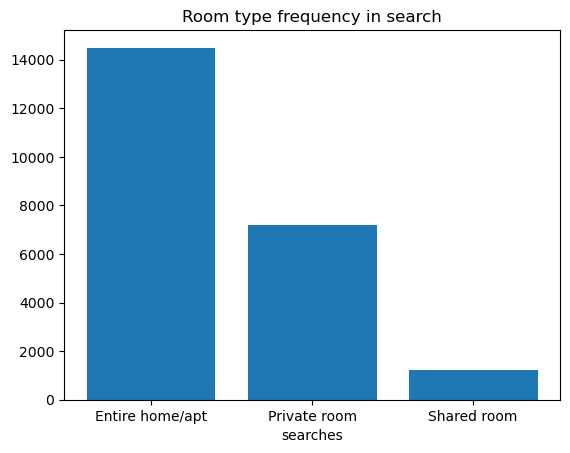

In [8]:
#Types of room searched for
room_filter = searches['filter_room_types'].copy().dropna()

#As users can choose several room types at one search, create loop to separate them
room_list = []
for sets in room_filter:
    for room in sets.split(','):
        room_list.append(room)

#Create DataFrame based on list and clean up blank cells
room_df = pd.DataFrame(room_list, columns=['type'])
room_df.drop(room_df[room_df['type']==''].index, inplace=True)

#Group by type to find total times when each type occurs in searches
types_grouped = room_df.groupby('type').size().reset_index(name='count')

#Build bar chart
plt.bar(types_grouped['type'], types_grouped['count'])
plt.xlabel('searches')
plt.title('Room type frequency in search')

plt.show()

Most of users look for entire house

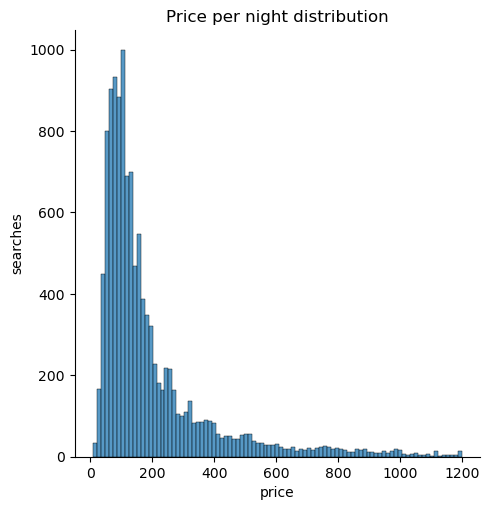

In [9]:
#Max costs of housing

#'filter_price_max' has extreme outliers, it seems that some error occurs during data collection
#So, keep only values that below 1200 (10% of data is beyond this)
cleaned_price = searches[searches['filter_price_max'] <= 1200]['filter_price_max']

#Build histogram
sns.displot(x=cleaned_price)
plt.xlabel('price')
plt.ylabel('searches')
plt.title('Price per night distribution')

plt.show()

In [10]:
#Neighorhood preferences

#96% searches field 'filter_neighborhoods' have null values, it can be either due to data collection error or just because most users don't apply that
#Let's assume 2nd scenario (don't apply) -> fill in null values as 'No matter'
neighborhood = searches['filter_neighborhoods'].fillna('No matter')

#As users can choose several neighborhoods at one search, create loop to separate them
nhood_list = []
for items in neighborhood:
    for item in items.split(','):
        nhood_list.append(item)

#Create DataFrame based on list and clean up blank cells
nhood_df = pd.DataFrame(nhood_list, columns=['name'])
nhood_df.drop(nhood_df[nhood_df['name']==''].index, inplace=True)

#Group neighborhoods to find total times when each occurs in search
nhood_grouped = nhood_df.groupby('name').size().reset_index(name='count')

#Show top 5
top_5_nhoods = nhood_grouped.nlargest(5, 'count').reset_index(drop=True)
top_5_nhoods

,name,count
0,No matter,34391
1,City Centre,1164
2,Temple Bar,193
3,Old City,156
4,Docklands,105


 Based on the table, mostly users aren't interested in some specific neighborhood, but 'Cityt Center' is a common choice

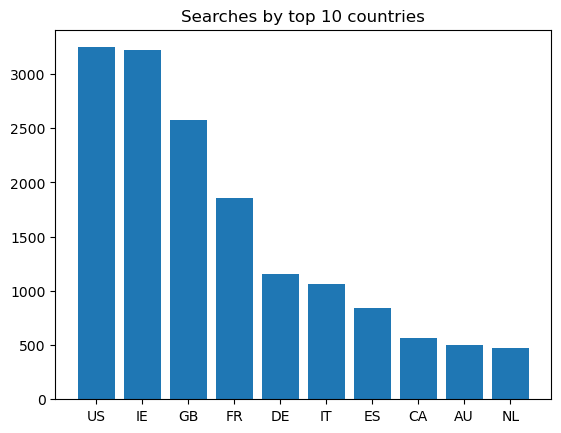

In [11]:
#User's origin country variation
user_country = searches[['id_user', 'origin_country']]

#Group by country to find unique users
country = user_country.groupby('origin_country').id_user.nunique().reset_index()

#As users from 131 country are interested in Dublin, let's keep top 10 of them
top_10_counrty = country.nlargest(10, 'id_user').reset_index(drop=True)

#Build bar chart
plt.bar(top_10_counrty['origin_country'], top_10_counrty['id_user'])
plt.title('Searches by top 10 countries')

plt.show()

The chart shows that users from English-speaking countries are most interested in going to Dublin

## Hosts Acceptance Exploration <a id="host_accpt"></a>
On this stage the following points will be explored:
1. How many nights most accepted for hosts?
2. How many guests usually hosts tend to accept?
3. Demand and acceptance over months


In [12]:
#Change string date fields to datetime format for easier analysis
contacts['ts_contact_at'] = pd.to_datetime(contacts['ts_contact_at'])
contacts['ts_reply_at'] = pd.to_datetime(contacts['ts_reply_at'])
contacts['ts_accepted_at'] = pd.to_datetime(contacts['ts_accepted_at'])
contacts['ts_booking_at'] = pd.to_datetime(contacts['ts_booking_at'])
contacts['ds_checkin'] = pd.to_datetime(contacts['ds_checkin'])
contacts['ds_checkout'] = pd.to_datetime(contacts['ds_checkout'])

#Add status 'Accepted' / 'Not accepted' to each contact
contacts['status'] = contacts.ts_accepted_at\
    .apply(lambda x: 'Accepted' if pd.notna(x) else 'Not Accepted')

In [13]:
#Undrstand types of data in the dataset
contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_guest        7823 non-null   object        
 1   id_host         7823 non-null   object        
 2   id_listing      7823 non-null   object        
 3   ts_contact_at   7823 non-null   datetime64[ns]
 4   ts_reply_at     7219 non-null   datetime64[ns]
 5   ts_accepted_at  3627 non-null   datetime64[ns]
 6   ts_booking_at   2174 non-null   datetime64[ns]
 7   ds_checkin      7823 non-null   datetime64[ns]
 8   ds_checkout     7823 non-null   datetime64[ns]
 9   n_guests        7823 non-null   int64         
 10  n_messages      7823 non-null   int64         
 11  status          7823 non-null   object        
dtypes: datetime64[ns](6), int64(2), object(4)
memory usage: 733.5+ KB


In [14]:
#Understand basic statistics and outliers
contacts.describe()

,n_guests,n_messages
count,7823.000000,7823.000000
mean,2.422600,6.319954
std,1.617347,6.472827
min,1.000000,1.000000
25%,1.000000,2.000000
50%,2.000000,4.000000
75%,3.000000,8.000000
max,16.000000,102.000000


In [15]:
#Look at overall acceptance ratio
accept_ratio = contacts[contacts.status=='Accepted'].shape[0] / contacts.shape[0]
accept_ratio

0.46363287741275727

In [16]:
#Let's look at acceptence in terms of the number of nights
#Add field 'n_nights_conf' to determine num of confirmed nights in list
contacts['n_nights_cont'] = contacts['ds_checkout'] - contacts['ds_checkin']
contacts['n_nights_cont'] = contacts['n_nights_cont'].dt.days #change data type to int

#Bulid pivot table for each day option
nights_status = contacts.groupby(['n_nights_cont', 'status']).size().reset_index(name='count')
nights_status_pivot = nights_status.pivot(columns='status', index='n_nights_cont', values='count').reset_index()

nights_status_pivot['Accepted'].fillna(0, inplace=True) #replace null values (if no accepted days)

#Add 'Total contacts' column
nights_status_pivot['Total contacts'] = nights_status_pivot['Accepted'] + nights_status_pivot['Not Accepted']

nights_status_pivot.head()

status,n_nights_cont,Accepted,Not Accepted,Total contacts
0,1,483.0,667.0,1150.0
1,2,854.0,897.0,1751.0
2,3,890.0,880.0,1770.0
3,4,543.0,613.0,1156.0
4,5,227.0,251.0,478.0


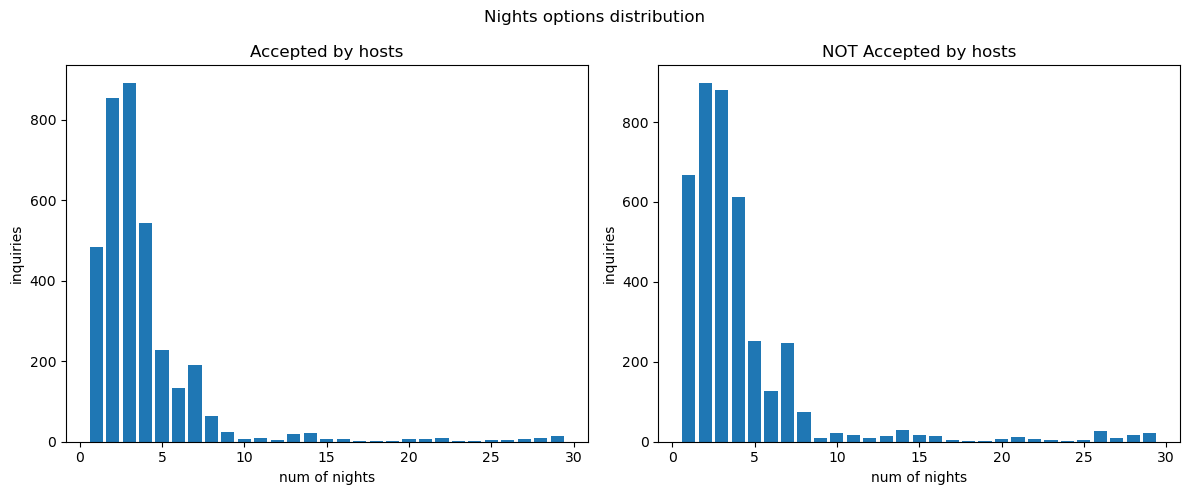

In [17]:
#Like in searchers distribution set limit up to 29 day (95 percentile)
nights_status_pivot_29 = nights_status_pivot[nights_status_pivot['n_nights_cont'] <= perc_95]

#Build two plots Accepted / NOT Accepted nights option distribution
plt.figure(figsize=(12, 5))
plt.suptitle('Nights options distribution')

plt.subplot(1, 2, 1)
plt.bar(nights_status_pivot_29['n_nights_cont'], nights_status_pivot_29['Accepted'])
plt.xlabel('num of nights')
plt.ylabel('inquiries')
plt.title('Accepted by hosts')

plt.subplot(1, 2, 2)
plt.bar(nights_status_pivot_29['n_nights_cont'], nights_status_pivot_29['Not Accepted'])
plt.xlabel('num of nights')
plt.ylabel('inquiries')
plt.title('NOT Accepted by hosts')

plt.tight_layout()
plt.show()

As it's shown on charts, 3-days is the most popular option for hosts to accept, meanwhile for searchers it's 2-days.
Also, 4-days option is higher accepted than 1-day option for searchers.\
So, hosts more tend to accept a little bit longer options range then users search.

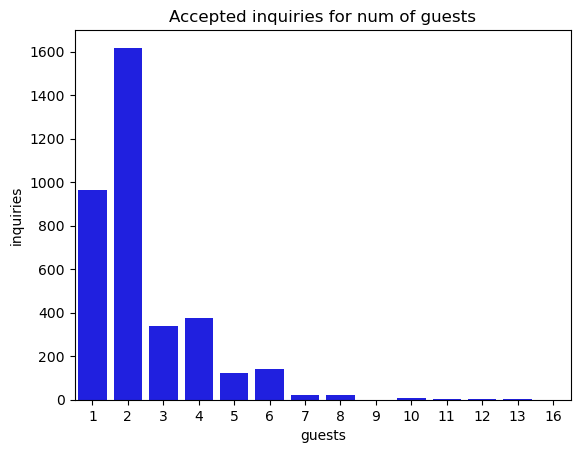

In [18]:
#Accepted inquiries for num of guests
guests_status = contacts.groupby(['n_guests', 'status']).size().reset_index(name='count')
guests_accptd = guests_status[guests_status['status']=='Accepted']

#Bulit bar chart
sns.barplot(data=guests_accptd, x='n_guests', y='count', errorbar=None, color='blue')
plt.xlabel('guests')
plt.ylabel('inquiries')
plt.title('Accepted inquiries for num of guests')

plt.show()

The most popular num of guest option is 2 for hosts, however for searchers is 1. In addition, 3-4 options are also common.\
We can make assumption that there are lack of supply for 1 bad rooms in the city.

In [19]:
#Let's look at demand over months. Use checkin date
month_accpt_rate = contacts.groupby([contacts['ds_checkin'].dt.month, 'status']).size()\
    .reset_index(name='count')\
    .pivot(columns='status', index='ds_checkin', values='count')\
    .reset_index()

#Add 'Accept ratio' and 'Total inquiries' for better visualisation
month_accpt_rate['Total inquiries'] = month_accpt_rate['Accepted'] + month_accpt_rate['Not Accepted']
month_accpt_rate['Accept ratio'] = month_accpt_rate['Accepted'] / month_accpt_rate['Total inquiries']

month_accpt_rate

status,ds_checkin,Accepted,Not Accepted,Total inquiries,Accept ratio
0,1,73,74,147,0.496599
1,2,46,52,98,0.469388
2,3,126,277,403,0.312655
3,4,26,10,36,0.722222
4,5,30,29,59,0.508475
5,6,18,24,42,0.428571
6,7,17,30,47,0.361702
7,8,11,25,36,0.305556
8,9,2,6,8,0.250000
9,10,1770,2162,3932,0.450153


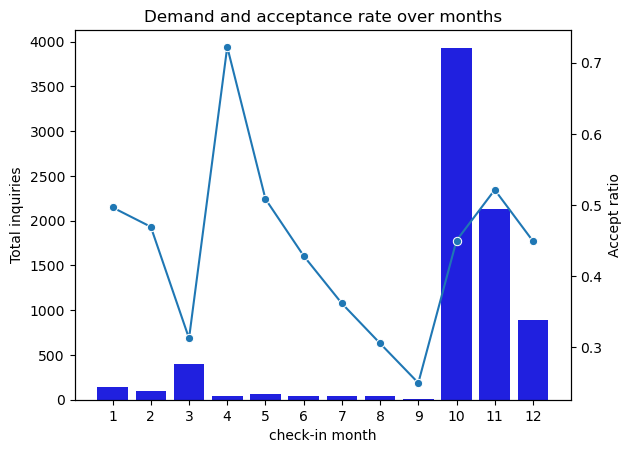

In [20]:
#Build bar chart along with line chart of acceptance ratio
fig, ax1 = plt.subplots()

#Bar chart
sns.barplot(data = month_accpt_rate, x='ds_checkin', y='Total inquiries', ax=ax1, color='blue')
plt.xlabel('check-in month')

ax2 = ax1.twinx() #add axis

#Line chart
sns.lineplot(data = month_accpt_rate['Accept ratio'], marker='o', sort = False, ax=ax2)
ax2.grid(False) #remove grid line
plt.title('Demand and acceptance rate over months')

plt.show()

It seems that the most popular month for a trip to Dubplin is October and overall fall-winter period. With the most acceptance rate in November (52.1%).\
Spring and summer is less popular seasons.


In [21]:
#Let's see if there is difference in acceptance rate for different price

#Merge datasets for more analysis
merged_datasets = contacts.merge(searches, left_on='id_guest', right_on='id_user')

In [22]:
#Write classification price function based on 'filter_price_max' ('filter_price_min' mostly zero)
def price_class(price):
    if price >= 0. and price < 100.:
        return '0-100'
    elif price >= 100. and price < 200.:
        return '100-200'
    elif price >= 200. and price < 300.:
        return '200-300'
    elif price >= 300. and price < 400.:
        return '300-400'
    elif price >= 400. and price < 500.:
        return '400-500'
    elif price >= 500. and price < 600.:
        return '500-600'
    elif price >= 600. and price < 700.:
        return '600-700'
    elif price >= 700. and price < 800.:
        return '700-800'
    elif price >= 800. and price < 900.:
        return '800-900'
    elif price >= 900. and price < 1000.:
        return '900-1000'
    else:
        return '1000+'

In [23]:
#Add column for price classification
merged_datasets['price_category'] = merged_datasets.filter_price_max.apply(price_class)

#Create pivot table and filter out values which above 1200 (10% of dataset)
price_cat_status = merged_datasets[merged_datasets['filter_price_max']<=1200]\
    .groupby(['price_category', 'status']).size()\
    .reset_index(name='count')\
    .pivot(columns='status', index='price_category', values='count')\
    .reset_index()

In [24]:
#Calculate acceptence ratio
price_cat_status['Accept ratio'] = price_cat_status['Accepted'] / (price_cat_status['Accepted'] + price_cat_status['Not Accepted'])

price_cat_status[['price_category', 'Accept ratio']]

status,price_category,Accept ratio
0,0-100,0.411160
1,100-200,0.430308
2,1000+,0.469880
3,200-300,0.431149
4,300-400,0.450488
5,400-500,0.485549
6,500-600,0.422297
7,600-700,0.424837
8,700-800,0.522013
9,800-900,0.380645


Inquiries accepted by host almost the same regardless price